<a href="https://colab.research.google.com/github/kokolight/MetacriticProject/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataScience Project


## Creating the data set - Crawling and API


### Main problem -
* Gaming companies develop games for years and cannot predict if their game will be sucessfull or not.

### Data -
Metacritic -

Description: Games ranking and reviews

Website: https://www.metacritic.com/

RAWG - 
Website: https://rawg.io

### Web scraping

### Data we scrape:
- Name
- Release Date
- Metascore
- Userscore

### Data we get from API
- Singleplayer - True/False
- Multiplayer - True/False
- Achievements count
- Youtube related videos count
- Average playtime
- Is part of a series
- Publisher
- Developer
- Which consoles
- What genres
- Maturaty Rating

### Imports

In [5]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import threading
import re
import os.path
from os import path
import json
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score, accuracy_score
from sklearn import preprocessing
from ast import literal_eval

### Variables

In [ ]:

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
}
RAWG_API_KEY = "2ae69e21c8c349e9816a0382283df150"
FILE_NAME = "video_games_ratings.csv"
BASE_URL = "https://www.metacritic.com"
BROWSE_URL = BASE_URL + "/browse/games/score/metascore/all/all/filtered?"
COLUMNS = [
    "game_name",
    "metascore",
    "userscore",
    "publisher",
    "developer",
    "release_date",
    "maturaty_rating",
    "singleplayer",
    "multiplayer",
    "onXbox",
    "onPC",
    "onPlaystation",
    "onSwitch",
    "onWii",
    "onMac",
    "onIOS",
    "onAndroid",
    "youtube_videos_count",
    "achievements_count",
    "ratings_count",
    "average_playtime",
    "game_series_count",
]

month_dict = {
    "January": "1",
    "February": "2",
    "March": "3",
    "April": "4",
    "May": "5",
    "June": "6",
    "July": "7",
    "August": "8",
    "September": "9",
    "October": "10",
    "November": "11",
    "December": "12",
}

 ### Function: Get all games data (by pages)


In [ ]:

def metacritic_games_data(start_page, end_page):
    index = 1
    game_records = []

    current_data = pd.read_csv(FILE_NAME, index_col=0) if path.exists(FILE_NAME) else pd.DataFrame(columns=COLUMNS)
    soup = BeautifulSoup(features="lxml")
    # Get all games in all pages
    for i in range(start_page, end_page):
        page_url = BROWSE_URL + "page={0}".format(i)
        req = requests.get(page_url, headers=HEADERS)
        soup.append(bs4.BeautifulSoup(req.text, "lxml"))

    trs = set(soup.select("tr"))
    spacers = set(soup.select("tr.spacer"))
    games = trs - spacers

    # For each game
    for game in games:
        game_name = game.select("h3")[0].text
        # Already exists
        if (not current_data.empty) and (game_name in current_data["game_name"].values):
            print(f"Already in dataframe - {game_name}")
            index = index + 1
            continue
        metascore = game.select("div.metascore_w.game")[0].text
        userscore = game.select("div.metascore_w.user.game")[0].text
        date = game.select("div.clamp-details")[0].find_all("span")[2].text.replace(",", "")
        date_splitted = date.split(" ")
        release_date = "{day}-{month}-{year}".format(
            day=date_splitted[1], month=month_dict[date_splitted[0]], year=date_splitted[2]
        )
        game_href = game.find("a", class_="title", href=True)["href"]
        game_slug = re.findall(".*\/(.*)$", game_href)[0]

        print(f"Game: {game_name}")

        game_object = get_game_data(game_slug, game_name, metascore, userscore, release_date)
        if len(game_object):
            game_records.append(game_object)
        else:
            print(f"Couldn't get game details: {game_name}")

        print("Progress: {:.2f}%".format((index / len(games)) * 100))
        index = index + 1
    
    new_data = pd.DataFrame(game_records)

    if not new_data.empty:
        current_data = current_data.append(new_data, ignore_index=True)
        current_data.to_csv("./video_games_ratings.csv", mode="w")
    return current_data

### Function: Get single game data

In [ ]:
def get_game_data(game_slug, game_name, metascore, userscore, release_date):
    rawg_details = get_game_rawg_details(game_slug)
    if len(rawg_details) == 0:
        return []

    return {
        "game_name": game_name,
        "release_date": release_date,
        "metascore": metascore,
        "userscore": userscore,
        "publisher": rawg_details["publisher"],
        "developer": rawg_details["developer"],
        "maturaty_rating": rawg_details["maturaty_rating"],
        "average_playtime": rawg_details["avg_playtime"],
        "achievements_count": rawg_details["achievements_count"],
        "youtube_videos_count": rawg_details["youtube_videos_count"],
        "singleplayer": rawg_details["singleplayer"],
        "multiplayer": rawg_details["multiplayer"],
        "onXbox": rawg_details["onXbox"],
        "onPC": rawg_details["onPC"],
        "onPlaystation": rawg_details["onPlaystation"],
        "onSwitch": rawg_details["onSwitch"],
        "onMac": rawg_details["onMac"],
        "onIOS": rawg_details["onIOS"],
        "onAndroid": rawg_details["onAndroid"],
        "ratings_count": rawg_details["ratings_count"],
        "genres": rawg_details["genres"],
        "game_series_count": rawg_details["game_series_count"],
    }

### Get game additional data from RAWG

In [ ]:
def get_game_rawg_details(game_name):
    try:
        RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
        data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Check if not redirected to another page
        while "redirect" in data:
            game_name = data["slug"]
            RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
            data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Not found
        if "detail" in data:
            return []
        if len(data):
            game_details = {
                "achievements_count": data["parent_achievements_count"],
                "avg_playtime": data["playtime"],
                "youtube_videos_count": data["youtube_count"],
                "singleplayer": False,
                "multiplayer": False,
                "game_series_count": data["game_series_count"],
                "maturaty_rating": data["esrb_rating"]["name"][0] if data["esrb_rating"] else None,
                "onXbox": False,
                "onPC": False,
                "onPlaystation": False,
                "onSwitch": False,
                "onWii": False,
                "onMac": False,
                "onIOS": False,
                "onAndroid": False,
                "genres": [],
                "platforms_count": len(data["platforms"]),
                "publisher": data["publishers"][0]["name"] if len(data["publishers"]) else None,
                "developer": data["developers"][0]["name"] if len(data["developers"]) else None,
                "ratings_count": data["ratings_count"],
            }
            for tag in data["tags"]:
                if tag["slug"] == "singleplayer":
                    game_details["singleplayer"] = True
                if tag["slug"] == "multiplayer":
                    game_details["multiplayer"] = True
            for platform in data["platforms"]:
                if bool(re.match("playstation", platform["platform"]["slug"])):
                    game_details["onPlastation"] = True
                if bool(re.match("xbox", platform["platform"]["slug"])):
                    game_details["onXbox"] = True
                if bool(re.match("pc", platform["platform"]["slug"])):
                    game_details["onPC"] = True
                if bool(re.match("switch", platform["platform"]["slug"])):
                    game_details["onSwitch"] = True
                if bool(re.match("macos", platform["platform"]["slug"])):
                    game_details["onMac"] = True
                if bool(re.match("ios", platform["platform"]["slug"])):
                    game_details["onIOS"] = True
                if bool(re.match("android", platform["platform"]["slug"])):
                    game_details["onAndroid"] = True
            for genre in data["genres"]:
                game_details["genres"].append(genre["slug"])
            return game_details
        else:
            print(f"{game_name} is not available!")
            return []
    except json.decoder.JSONDecodeError:
        print("There was a problem while decoding object...")
        return []


### Main - Retrieveing all the data

In [ ]:
df = metacritic_games_data(100, 150)
print(df)

# Exploring the data

In [6]:
def fill_esrb_data(df):
  df2 = df.copy()

def load_csv(filename):
  return pd.read_csv(filename, parse_dates=['release_date'])

def outlier_detection_iqr(df):
    df2 = df.copy()
    numeric_cols = df2.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        df2.loc[(df2[col] < Q1 - 1.5*IQR) | (df2[col] > Q3 + 1.5*IQR ),col] = np.nan
    return df2

def get_frequent_publishers(df, col_name, num_top_elements):
    return df[col_name].value_counts().head(num_top_elements)

In [14]:
# Loading the data
df = load_csv("video_games_ratings.csv")
# Drop first column
df = df.iloc[:, 1:]
df.drop(columns="onWiionMac")
df['genres'] = df['genres'].apply(literal_eval)
genres_df = pd.DataFrame({"genre", "rating"})
for genres in df['genres']:
  for genre in genres:
    genres_df.append({"genre": genre, "rating": "A"}, ignore_index=True)

KeyboardInterrupt: ignored

In [11]:
genres_df

[{'genre': 'sports', 'rating': 'A'},
 {'genre': 'simulation', 'rating': 'A'},
 {'genre': 'role-playing-games-rpg', 'rating': 'A'},
 {'genre': 'action', 'rating': 'A'},
 {'genre': 'adventure', 'rating': 'A'},
 {'genre': 'platformer', 'rating': 'A'},
 {'genre': 'action', 'rating': 'A'},
 {'genre': 'casual', 'rating': 'A'},
 {'genre': 'indie', 'rating': 'A'},
 {'genre': 'sports', 'rating': 'A'},
 {'genre': 'action', 'rating': 'A'},
 {'genre': 'shooter', 'rating': 'A'},
 {'genre': 'strategy', 'rating': 'A'},
 {'genre': 'adventure', 'rating': 'A'},
 {'genre': 'puzzle', 'rating': 'A'},
 {'genre': 'role-playing-games-rpg', 'rating': 'A'},
 {'genre': 'sports', 'rating': 'A'},
 {'genre': 'simulation', 'rating': 'A'},
 {'genre': 'sports', 'rating': 'A'},
 {'genre': 'racing', 'rating': 'A'},
 {'genre': 'sports', 'rating': 'A'},
 {'genre': 'action', 'rating': 'A'},
 {'genre': 'shooter', 'rating': 'A'},
 {'genre': 'sports', 'rating': 'A'},
 {'genre': 'role-playing-games-rpg', 'rating': 'A'},
 {'gen

In [ ]:
def prepare_dataset(df):
  # Dealing with 'bad' data - duplicates and null values
  df2 = df.copy()
  df2 = df2.dropna('publisher', 'developer'])
  df2 = df2.drop_duplicates(subset=['game_name'])

  # Dealing with missing userscore values
  df2 = df2.drop(df2[df2['userscore'] == 'tbd'].index)

  # Dealing with games that haven't been released yet
  today = pd.Timestamp('today')
  df2 = df2.drop(df2[df2['release_date'] > today].index)

  df2['userscore'] = df2['userscore'].astype(float)
  # Convert genres string to array
  df['genres'] = df['genres'].apply(literal_eval)

  # Making Boolean values to int
  df2['onXbox'] = df2['onXbox'].astype(int)
  df2['onPC'] = df2['onPC'].astype(int)
  df2['onPlaystation'] = df2['onPlaystation'].astype(int)
  df2['onSwitch'] = df2['onSwitch'].astype(int)
  df2['onWii'] = df2['onWii'].astype(int)
  df2['onMac'] = df2['onMac'].astype(int)
  df2['onIOS'] = df2['onIOS'].astype(int)
  df2['onAndroid'] = df2['onAndroid'].astype(int)
  df2['singleplayer'] = df2['singleplayer'].astype(int)
  df2['multiplayer'] = df2['multiplayer'].astype(int)

  df = df.reset_index(drop=True)

  # Reset indices
  return df2


df = prepare_dataset(df)
condition = df['average_playtime'] == 0
avg_playtime = df['average_playtime'].mean()
df.loc[condition, 'average_playtime'] = avg_playtime
df['average_playtime'] = df['average_playtime'].astype(int)
df



ValueError: ignored

In [ ]:
# Removing outliers
df = outlier_detection_iqr(df).dropna()

In [ ]:
# Exploring the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3608 entries, 1 to 13517
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   game_name             3608 non-null   object        
 1   metascore             3608 non-null   int64         
 2   userscore             3608 non-null   float64       
 3   publisher             3608 non-null   object        
 4   developer             3608 non-null   object        
 5   release_date          3608 non-null   datetime64[ns]
 6   maturity_rating       3608 non-null   object        
 7   singleplayer          3608 non-null   int64         
 8   multiplayer           3608 non-null   int64         
 9   onXbox                3608 non-null   int64         
 10  onPC                  3608 non-null   int64         
 11  onPlaystation         3608 non-null   int64         
 12  onSwitch              3608 non-null   int64         
 13  onWii            

In [ ]:
df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Userscore')

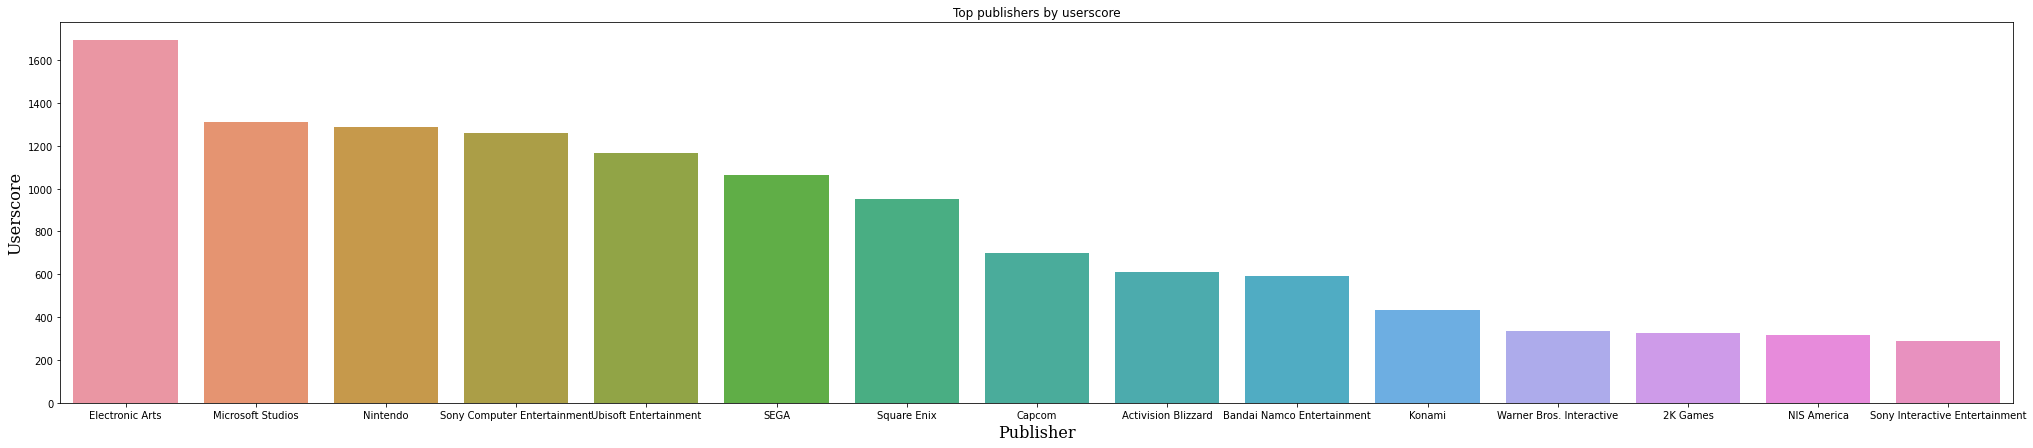

In [ ]:
def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type, ax=axis)

publishers = get_frequent_publishers(df, 'publisher', 10)
fig, axes = plt.subplots(1,1, figsize=(35,7))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
publishers_score = df.groupby("publisher")['userscore'].sum().sort_values(ascending=False).head(15)
ax = sns.barplot(publishers_score.index, publishers_score)
ax.set_title("Top publishers by userscore")
ax.set_xlabel("Publisher", font)
ax.set_ylabel("Userscore", font)


In [ ]:
df['metascore']/df['userscore']

0       10.449438
1       10.333333
2       10.329670
3       10.449438
4       10.108696
          ...    
2128     9.242424
2129     9.459459
2130     7.558140
2131    11.206897
2132     9.178082
Length: 2133, dtype: float64

In [ ]:
def get_highly_correlated_cols(df):
    correlations , tuple_arr = [],[]
    col_count = len(df.columns)
    for i in range(col_count):
        for j in range(i+1, col_count):
            pearson=df[df.columns[i]].corr(df[df.columns[j]])
            if pearson >=0.5:
                correlations.append(pearson)
                tuple_arr.append([i,j])
    return correlations, tuple_arr

In [ ]:

def cross_tabulation(df, col_name, other_col_name):
    return pd.crosstab(df[col_name], df[other_col_name], normalize='index')

def plot_cross_tabulation(df, col_names, other_col_name):
    fig=plt.figure(figsize=(20,5))
    for i in range(len(col_names)):
        subplot=fig.add_subplot(1, 5, i+1)
        sr=cross_tabulation(df,col_names[i], other_col_name)
        one_dim_plot(sr, 'line' , subplot)
df_crosstab = cross_tabulation(df, 'metascore', 'userscore')
df_crosstab

# plot_cross_tabulation(df, ['metascore', 'userscore'], ['average_playtime'])

userscore,0.5,1.1,1.3,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,...,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.7
metascore,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025,0.0,0.0,0.025000,0.000000,0.025,0.000000,0.000000,0.050000,0.025,0.000000,0.125000,0.000000,0.000000,0.050000,0.075000,0.025000,0.075000,0.150000,0.150000,0.100000,0.000000,0.000000,0.075000,0.0,0.000000,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.028571,0.057143,0.000,0.028571,0.000000,0.000000,0.000,0.028571,0.028571,0.057143,0.057143,0.028571,0.085714,0.028571,0.114286,0.114286,0.028571,0.142857,0.057143,0.057143,0.057143,0.0,0.000000,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
avg_playtime_mean = df['average_playtime'].mean()
above_avg = df[df['average_playtime'] > 3 * avg_playtime_mean]
avg = df[(df['average_playtime'] < (3 * avg_playtime_mean)) & (df['average_playtime'] > avg_playtime_mean)]
below_avg = df[df['average_playtime'] < avg_playtime_mean]

sns.barplot()

,game_name,metascore,userscore,publisher,developer,release_date,maturity_rating,singleplayer,multiplayer,onXbox,onPC,onPlaystation,onSwitch,onWii,onMac,onIOS,onAndroid,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,genres
3,Transformers: Fall of Cybertron,79.0,8.5,Activision Blizzard,Activision,2012-08-21,T,True,True,True,True,False,False,False,False,False,False,722102.0,101.0,109.0,6.0,1.0,"['action', 'shooter']"
44,The World Ends with You,88.0,8.7,Square Enix,Square Enix,2008-04-22,E,False,False,False,False,False,False,False,False,False,True,1000000.0,0.0,61.0,10.0,1.0,['arcade']
70,Warlords Battlecry,82.0,7.8,Ubisoft Entertainment,Strategic Studies Group,2000-09-07,T,True,True,False,True,False,False,False,False,False,False,0.0,0.0,7.0,10.0,0.0,"['role-playing-games-rpg', 'strategy']"
79,TOCA Race Driver 3,82.0,7.5,Codemasters,Codemasters,2006-02-22,E,False,False,True,True,False,False,False,True,False,False,164344.0,0.0,15.0,6.0,0.0,"['simulation', 'sports', 'racing', 'arcade']"
87,Mario & Luigi: Partners in Time,86.0,8.5,Nintendo,AlphaDream,2005-11-28,E,False,False,False,False,False,False,False,False,False,False,897092.0,0.0,53.0,6.0,0.0,['role-playing-games-rpg']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,OVERKILL's The Walking Dead,51.0,5.2,Starbreeze publishing,505 Games,2018-06-11,M,False,False,True,True,False,False,False,False,False,False,164961.0,38.0,36.0,6.0,0.0,['action']
2270,N.E.R.O.: Nothing Ever Remains Obscure,59.0,6.4,SOEDESCO Publishing,SOEDESCO Publishing,2016-06-24,E,True,False,True,True,False,False,False,False,False,False,10910.0,24.0,6.0,6.0,0.0,"['adventure', 'role-playing-games-rpg', 'indie..."
2300,Saint Seiya: Soldiers' Soul,59.0,7.5,Bandai Namco Entertainment,BANDAI NAMCO Entertainment America,2015-06-10,T,True,True,False,True,False,False,False,False,False,False,0.0,40.0,19.0,6.0,0.0,"['action', 'fighting']"
2317,Mugen Souls,55.0,7.2,Ghostlight,NIS America,2012-10-16,T,True,False,False,True,False,False,False,False,False,False,151228.0,32.0,9.0,6.0,0.0,"['adventure', 'role-playing-games-rpg', 'strat..."


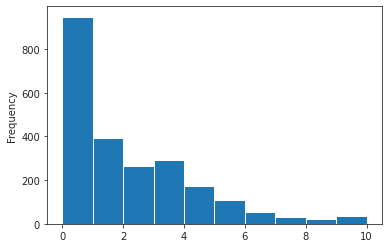

In [ ]:
sns.set_style('ticks')

df['average_playtime'].plot(kind='hist')

In [ ]:
years = [2000, 2005, 2010,2015, 2020]
yearsByDate = [date.year for date in df['release_date']]
a = pd.cut(yearsByDate, years)
df['a'] = a
df

In [ ]:
drop_columns = ["game_name", "publisher", "developer", "genres", "userscore", "average_playtime"]
X = df.drop(columns=drop_columns, axis=1)
X['release_year'] = [date.year for date in df['release_date']]
X = X.drop(columns=["release_date"], axis=1)
X = pd.get_dummies(X, columns=["maturity_rating"])
y = df['userscore'].astype(int)
X.info()

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)
df2


# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3608 entries, 1 to 13517
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   metascore             3608 non-null   int64
 1   singleplayer          3608 non-null   int64
 2   multiplayer           3608 non-null   int64
 3   onXbox                3608 non-null   int64
 4   onPC                  3608 non-null   int64
 5   onPlaystation         3608 non-null   int64
 6   onSwitch              3608 non-null   int64
 7   onWii                 3608 non-null   int64
 8   onMac                 3608 non-null   int64
 9   onIOS                 3608 non-null   int64
 10  onAndroid             3608 non-null   int64
 11  youtube_videos_count  3608 non-null   int64
 12  achievements_count    3608 non-null   int64
 13  ratings_count         3608 non-null   int64
 14  game_series_count     3608 non-null   int64
 15  release_year          3608 non-null   int64
 16  matur

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.672420,0.000000,0.013421,0.750000,0.16,0.0,0.0,1.0,0.0,0.0
1,0.986667,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,0.240218,0.071429,0.28,0.0,0.0,1.0,0.0,0.0
2,0.973333,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355496,0.007299,0.147634,0.464286,0.28,0.0,0.0,1.0,0.0,0.0
3,0.986667,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139195,0.027007,0.033894,0.214286,0.32,0.0,0.0,0.0,0.0,1.0
4,0.986667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006824,0.000000,0.16,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,0.173333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016699,0.036496,0.001365,0.000000,0.56,0.0,0.0,0.0,0.0,1.0
3604,0.253333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.56,0.0,0.0,0.0,0.0,1.0
3605,0.306667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012511,0.000000,0.32,0.0,1.0,0.0,0.0,0.0
3606,0.186667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.050365,0.007507,0.000000,0.68,0.0,0.0,0.0,0.0,1.0


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

model_predict = model.predict(X_test)

model_accuracy = accuracy_score(y_test, model_predict)
model_accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.3545706371191136